In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import linalg
from sklearn.preprocessing import normalize
import csv
from sklearn.linear_model import lasso_path
# from numpy.linalg import multi_dot

In [2]:
# system size
n = 1

# parameters

In [3]:
def MMKinetics(t, x):
    Vmax, Km, k = 1.5, 0.3, 0.6
    return k - np.divide(Vmax*x, (Km+x))

def newmm(t,x):
    k1, k2, k3, k4 = 0.1295, -0.6474, 0.2158, 0.7194
    return np.divide((k1 + k2*x), (k3 + k4*x))

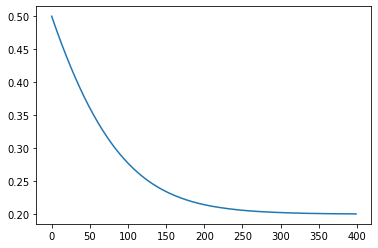

In [65]:
tspan = np.linspace(0.01, 4, num=400)
dt = 0.01
ini = [0.5]
sol = integrate.solve_ivp(MMKinetics, [tspan[0], tspan[-1]], ini, method='RK45', t_eval=tspan)#solver; np.size=400; (400,)
sol2 = integrate.solve_ivp(newmm, [tspan[0], tspan[-1]], ini, method='RK45', t_eval=tspan)
plt.plot(sol.y[0])
# plt.plot(sol2.y[0])
plt.show()

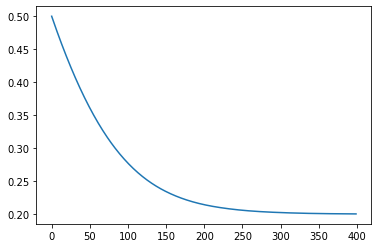

In [66]:
plt.plot(sol2.y[0])
plt.show()

In [67]:
sol_dx = MMKinetics(sol.t, sol.y)
# plt.show()
exp_data = sol_dx  #shape:(1,400)

In [68]:
#add noise to 'x'
eps = 1e-4  #float; magnitude of noise
SIZE = np.size(sol.y[0])
sol_noise=sol.y+eps*np.random.normal(0,1,(SIZE))#np.size=400; shape=(1,400); type=numpy.ndarray
#calculate the corresponding derivative
sol_noise_dx = MMKinetics(sol.t, sol_noise)

In [69]:
sol_noise_dx.shape

(1, 400)

In [70]:
#add noise to 'dx'
eps = 0  #???
SIZE = np.size(sol_dx)
sol_dx_noise=sol_dx+eps*np.random.normal(0,1,(SIZE))#shape=(1,400); type=numpy.ndarray

In [71]:
sol_dx_Noise = sol_dx_noise[0]#shape=(400,)

In [72]:
# sol_dx_Noise.shape

In [73]:
# sol_dx_noise

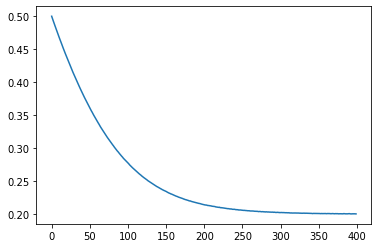

In [74]:
#figure(5) in MATLAB
# sol_Noise = sol_noise[0]
plt.plot(sol_noise[0])
plt.show()

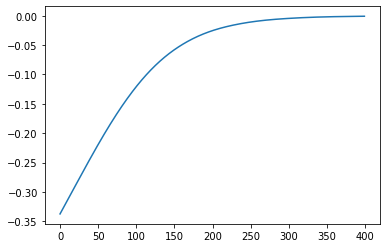

In [75]:
#figure(6) in MATLAB
plt.plot(sol_dx_Noise)
plt.show()

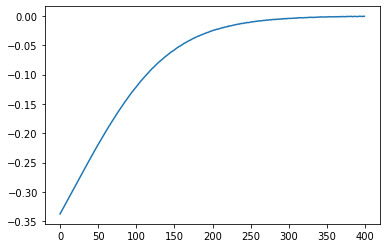

In [76]:
plt.plot(sol_noise_dx[0])
plt.show()

In [77]:
def data_aug(sol_):
    n = len(sol_)
    m = sol_.size
    for i in range(n):
        sol_ = np.vstack((sol_, sol_[i]**2))
    for i in range(n):
        for j in range(i+1, n):
            sol_ = np.vstack((sol_, sol_[i]*sol_[j]))
    for i in range(n):
        for j in range(n, 2*n):
            sol_ = np.vstack((sol_, sol_[i]*sol_[j]))
    sol_ = np.vstack((np.ones((1, m)), sol_))
    return sol_


def data_derivative(sol_,d_sol_):
    n = len(sol_)
    for i in range(n):
        sol_ = np.vstack((sol_, np.multiply(sol_[i], d_sol_)))
    return sol_


In [92]:
#test noise-added data
sol.y = sol_noise
sol_dx = sol_noise_dx
# sol_dx = sol_dx_noise  # does not work

In [93]:
term_lib = data_aug(sol.y)
term_lib = data_derivative(term_lib, sol_dx).T#x,x^2,dx*x...; ## transpose ## 400*8

In [89]:
def soft_thresholding(X, lambda_):
    temp_compare = X.T.copy()
    for i in range(len(X)):
        if abs(X[i]) - lambda_ < 0:
            temp_compare[:,[i]]= 0
        else:
            temp_compare[:, [i]] = abs(X[i]) - lambda_
    # tmp_compare = X[np.where(abs(X) - lambda_ > 0)]
    # tmp_compare = np.expand_dims(tmp_compare, axis =1)
    return np.multiply(np.sign(X), temp_compare.T)


def ADM(lib_null,q_init,lambda_,MaxIter, tol):
    q = q_init.copy()
    for i in range(MaxIter):
        q_old = q.copy()
        x = soft_thresholding(lib_null @ q_init, lambda_)
        temp_ = lib_null.T @ x
        q = temp_/ np.linalg.norm(temp_, 2)
        res_q = np.linalg.norm(q_old - q ,2)

        if res_q <= tol:
            return q


def ADMinitvary(lib_null, lambda_, MaxIter, tol, pflag):
    lib_null_norm = lib_null.copy()
    for i in range(len(lib_null[0])):
        lib_null_norm[:,i] = lib_null[:,i]/lib_null[:,i].mean()

    q_final = np.empty_like(lib_null.T)
    out = np.zeros((len(lib_null), len(lib_null)))
    nzeros = np.zeros((1, len(lib_null)))
    for i in range(len(lib_null_norm)):
        q_ini = lib_null_norm[[i],:].T
        temp_q = ADM(lib_null, q_ini, lambda_, MaxIter, tol)
        q_final[:,[i]] = temp_q
        temp_out = lib_null @ temp_q
        out[:,[i]] = temp_out
        nzeros_temp = sum(list((abs(temp_out) < lambda_)))
        nzeros[:,[i]] = float(nzeros_temp)
    idx_sparse = np.where(nzeros == max(np.squeeze(nzeros)))[0]
    ind_lib = np.where(abs(out[:, idx_sparse[0]]) >= lambda_)[0]
    Xi = out[:, idx_sparse[0]]
    small_idx = np.where(abs(out[:, idx_sparse[0]]) < lambda_)[0]
    Xi[small_idx] = 0
    numterms = len(ind_lib)
    return ind_lib, Xi, numterms

# def ADMpareto(term_lib, tol, pflag):
#     lib_null = linalg.null_space(term_lib)
#     num = 1
#     lambda_ = 1e-8
#     MaxIter = 10000
#     dic_lib = {}
#     dic_Xi = {}
#     dic_num = {}
#     dic_error = {}
#     dic_lambda = {}
#     ii = 0
#     while num > 0:
#         temp_ind_lib, temp_Xi, temp_numterms = ADMinitvary(lib_null, lambda_, MaxIter, tol, pflag)
#         dic_lib[ii] = temp_ind_lib
#         dic_Xi[ii] = temp_Xi
#         dic_num[ii] = temp_numterms

#         error_temp = sum(np.matmul(term_lib, dic_Xi[ii]))
#         dic_error[ii] = error_temp
#         dic_lambda[ii] = lambda_
#         lambda_ *= 2
#         num = dic_num[ii]
#         ii += 1
#         if lambda_ > 0.5:
#             break

#     return dic_Xi, dic_lib, dic_lambda, dic_num, dic_error

In [114]:
#def optimal_SVHT_coef
def IfElse(Q,point,counterPoint):
    #if Q, POINT, COUNTERPOINT ARE arrays???; len(point) should equal or greater than len(Q)!
    y=point;
    P=np.zeros(len(Q))
    # P is 'not Q or ~Q'
    for q in range(len(Q)):
        if Q[q]==0:
            P[q]=1
    if len(counterPoint)==1:
        counterPoint = counterPoint*np.ones(len(Q))

    for p in range(len(P)):
            
        if P[p]==1:
            y[p]=counterPoint[p]
    
    return y

def Fun_MarPas(x,beta,gamma):
    topSpec = (1 + np.sqrt(beta))**2
    botSpec = (1 - np.sqrt(beta))**2
    Q=(topSpec-x)*(x-botSpec)
    for q in range(len(Q)):
        if Q[q]>0:
            Q[q]=1
        else:
            Q[q]=0
    point = np.sqrt((topSpec-x)*(x-botSpec))/(beta*x)/(2*np.pi)  
    InitialMar = IfElse(Q,point,np.array([0])) #'0' number used to replace others
    if np.all(gamma != 0):
        return np.power(list(x),list(gamma))*InitialMar
    else:
        return InitialMar
    
    
    
#### separate
def MarPas(x,beta):
    topSpec = (1 + np.sqrt(beta))**2
    botSpec = (1 - np.sqrt(beta))**2
    Q=(topSpec-x)*(x-botSpec)
    for q in range(len(Q)):
        if Q[q]>0:
            Q[q]=1
        else:
            Q[q]=0
    point = np.sqrt((topSpec-x)*(x-botSpec))/(beta*x)/(2*np.pi)  
    InitialMar = IfElse(Q,point,np.array([0])) #########9#####0
#     if np.all(gamma != 0):
#         return np.power(list(x),list(gamma))*InitialMar
#     else:
#         return InitialMar
    return InitialMar

def incMarPas(x0,beta,gamma):
    #beta is an array including one (****or more****not true) number; 0<beta<=1 
    #x0 is an array with multiple numbers!!!
#     for b in beta: 
#         if b > 1:
#             raise Exception('dimension error')
    topSpec = (1 + np.sqrt(beta))**2
#     botSpec = (1 - np.sqrt(beta))**2
    x2=lambda x: Fun_MarPas(x,beta,gamma)
    I1 = np.zeros([len(x0)])#I1 is integrate collection
    I2 = np.zeros([len(x0)])
    for i in range(len(x0)):
        X0=x0[i]
        RES = integrate.quad(x2,np.array([X0]), topSpec)
        I1[i] = RES[0]
        I2[i] = RES[1]
#     return integrate.quad(x2, x0, topSpec)  #the first part of return is integrate
    return I1

#if inputs are arrarys including multiple numbers?
def incMarPas2(x0,beta,gamma):
    #beta is an array including one or more numbers; 0<beta<=1
#     for b in beta: 
#         if b > 1:
#             raise Exception('dimension error')
    topSpec = (1 + np.sqrt(beta))**2   #is an array including multiple numbers if beta is an array including multiple numbers
        

    I1 = np.zeros([len(beta)])
    I2 = np.zeros([len(beta)])
    for i in range(len(beta)):
        BETA = beta[i]
        GAMMA = gamma[i]
        x2=lambda x: Fun_MarPas(x,np.array([BETA]),np.array([GAMMA]))
        X0=x0[i]
        TOPSPEC=topSpec[i]
        RES = integrate.quad(x2,np.array([X0]), np.array([TOPSPEC]))
        I1[i] = RES[0]
        I2[i] = RES[1]
    return I1, I2

def MedianMarcenkoPastur(beta):
    #beta should be one number array!!!here
#     MarPas = lambda x: 1-incMarPas(x,beta,np.array([0]))
    lobnd = (1-np.sqrt(beta))**2
    hibnd = (1+np.sqrt(beta))**2
    change = 1
    while change and (hibnd - lobnd > 0.001):
        change = 0;
        x = np.linspace(start = lobnd, stop = hibnd, num = 5)
        y = np.zeros(len(x))
        for i in range(len(x)):
            y[i] = 1-incMarPas(x[i],beta,0)
        if any(y<0.5):
            lobnd = max(x[y < 0.5])
            change = 1
        if any(y>0.5):
            hibnd = min(x[y > 0.5])
            change = 1
    return (hibnd+lobnd)/2

def optimal_SVHT_coef_sigma_known(beta):
    #lambda_star
    #omit ensuring beta
    w = (8*beta)/(beta+1+np.sqrt(beta**2+14*beta+1))
    lambda_star = np.sqrt(2*(beta+1)+w)
    return lambda_star

def optimal_SVHT_coef_sigma_unknown(beta):
    coef = optimal_SVHT_coef_sigma_known(beta)
    MPmedian = np.zeros(len(beta))
    for i in range(len(beta)):
        MPmedian[i] = MedianMarcenkoPastur(beta)
    return coef/np.sqrt(MPmedian)

def optimal_SVHT_coef(beta,noiselevel):
    if noiselevel == 0:
        return optimal_SVHT_coef_sigma_unknown(beta)
    else:
        return optimal_SVHT_coef_sigma_known(beta)

In [120]:
# #test
# optimal_SVHT_coef(np.array([0.22]),0)[0]

In [153]:
m,n = term_lib.shape  #(400,8)
beta = np.array([m/n])
threshold = optimal_SVHT_coef(beta,0)[0]
# threshold
ydi = np.diag(term_lib)  #(8,)
# ydi.shape
ydi2 = np.copy(ydi)  #(8,)
# ydi2.shape
ydi2[ydi2 < threshold*np.median(ydi2)] = 0 #(8,)
# ydi2.shape
u, s, vh = np.linalg.svd(term_lib, full_matrices=False)
# u.shape # (400,8)
# s.shape  #(8,)
# vh.shape  #(8,8)
# np.diag(ydi2).shape  #(8,8)
np.diag(ydi2)
ydi2

array([1.        , 0.49650791, 0.24326919, 0.11772717, 0.        ,
       0.        , 0.        , 0.        ])

In [157]:

np.linalg.multi_dot([u,np.diag(ydi2),vh.T])

array([[ 0.02956634,  0.07259054,  0.04487964, ..., -0.00750856,
         0.01153358,  0.00236656],
       [ 0.03000324,  0.07069274,  0.04237711, ..., -0.00716961,
         0.00970333,  0.00175558],
       [ 0.03041514,  0.06891348,  0.04004127, ..., -0.00688717,
         0.00801003,  0.00114015],
       ...,
       [ 0.05122964,  0.00338232,  0.0017126 , ..., -0.00676449,
         0.00574668, -0.00767137],
       [ 0.05122941,  0.00339641,  0.00176932, ..., -0.00671598,
         0.00579124, -0.0075741 ],
       [ 0.05122955,  0.00340058,  0.00178798, ..., -0.0067023 ,
         0.00580687, -0.00754514]])

In [161]:
#add noise reduction in ADMpareto; replace previous ADMpareto
def ADMpareto(term_lib, tol, pflag):
    #####
    u, s, vh = np.linalg.svd(term_lib, full_matrices=False)
    m,n = term_lib.shape  #m/n aspect ratio of matrix to be denoised?
    ydi = np.diag(term_lib)
    beta = np.array([m/n])
    threshold = optimal_SVHT_coef(beta,0)[0]
    ydi2 = np.copy(ydi)
    ydi2[ydi2 < threshold*np.median(ydi2)] = 0
    term_lib2 = np.linalg.multi_dot([u,np.diag(ydi2),vh.T])  #####no .T?
    #####
    lib_null = linalg.null_space(term_lib2) #2
    num = 1
    lambda_ = 1e-8
    MaxIter = 10000

    dic_lib = {}
    dic_Xi = {}
    dic_num = {}
    dic_error = {}
    dic_lambda = {}
    ii = 0
    while num > 0:
        temp_ind_lib, temp_Xi, temp_numterms = ADMinitvary(lib_null, lambda_, MaxIter, tol, pflag)
        dic_lib[ii] = temp_ind_lib
        dic_Xi[ii] = temp_Xi
        dic_num[ii] = temp_numterms

        error_temp = sum(np.matmul(term_lib, dic_Xi[ii]))
        dic_error[ii] = error_temp
        dic_lambda[ii] = lambda_
        lambda_ *= 2
        num = dic_num[ii]
        ii += 1
        if lambda_ > 0.5:
            break

    return dic_Xi, dic_lib, dic_lambda, dic_num, dic_error

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  


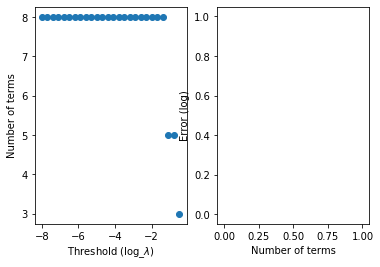

In [163]:
tol, pflag = 1e-5,1
dic_Xi, dic_lib, dic_lambda, dic_num, dic_error = ADMpareto(term_lib,tol, pflag)
lambda_vec = list(dic_lambda.values())
terms_vec = list(dic_num.values())
err_vec = list(dic_error.values())
log_err_vec = np.log10(err_vec)
log_lambda_vec = np.log10(lambda_vec)

plt.subplot(1,2,1)
plt.scatter(log_lambda_vec, terms_vec)
plt.xlabel("Threshold (log_$\lambda$)")
plt.ylabel("Number of terms")
plt.subplot(1,2,2)
plt.scatter(terms_vec, log_err_vec)
plt.xlabel("Number of terms")
plt.ylabel("Error (log)")
plt.show()

In [164]:
def new_MMKinetics(term_lib, dic_Xi, n):
    half_count = int(term_lib.shape[1] /2)
    total_xi = len(dic_Xi)
    #term_coff = dic_Xi[total_xi - n]
    term_coff = [0.18, -0.9, 0, 0, 0.3, 1, 0, 0]
    print(term_coff)
    return -np.divide(np.matmul(term_lib[:,:half_count], term_coff[:half_count]),
                      np.matmul(term_lib[:,half_count:], term_coff[half_count:]))

[0.18, -0.9, 0, 0, 0.3, 1, 0, 0]


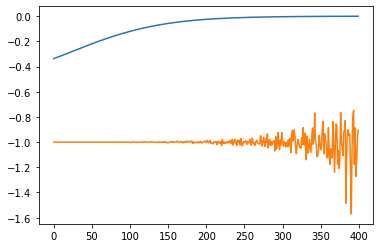

In [165]:
res2 = new_MMKinetics(term_lib, dic_Xi, 4)
plt.plot(sol_dx[0])
plt.plot(res2)
plt.show()